1. Outlier Detection and Feature Reduction

In [2]:

import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold


df = pd.read_csv("patient_data.csv")


numeric_df = df.select_dtypes(include=[np.number])  

selector = VarianceThreshold()  
selector.fit(numeric_df)       

constant_columns = numeric_df.columns[~selector.get_support()]
df_reduced = df.drop(columns=constant_columns)

print("Constant Columns Removed:", constant_columns.tolist())


Q1 = df_reduced["CholesterolLevel"].quantile(0.25)
Q3 = df_reduced["CholesterolLevel"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outliers = df_reduced[(df_reduced["CholesterolLevel"] >= lower_bound) &
                            (df_reduced["CholesterolLevel"] <= upper_bound)]

print(f"Rows before outlier removal: {len(df)}")
print(f"Rows after outlier removal: {len(df_no_outliers)}")


df_cleaned = df_no_outliers.fillna(df_no_outliers.median(numeric_only=True))


print("\nMissing values after cleaning:\n", df_cleaned.isnull().sum())
df_cleaned.head()



Constant Columns Removed: []
Rows before outlier removal: 100
Rows after outlier removal: 98

Missing values after cleaning:
 PatientID           0
Gender              0
Age                 0
CholesterolLevel    0
BloodPressure       0
Region              0
RiskCategory        0
dtype: int64


,PatientID,Gender,Age,CholesterolLevel,BloodPressure,Region,RiskCategory
0,1,Male,37,193.4,129.4,East,High
1,2,Female,45,210.7,107.1,West,Low
2,3,Male,63,244.3,103.9,West,Low
3,4,Male,53,184.5,127.2,West,High
4,5,Male,29,175.7,116.6,South,High


2.  Data Visualization

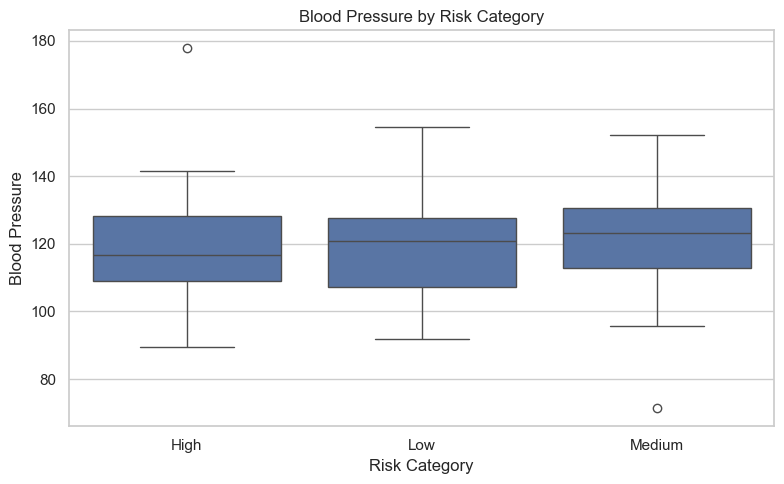

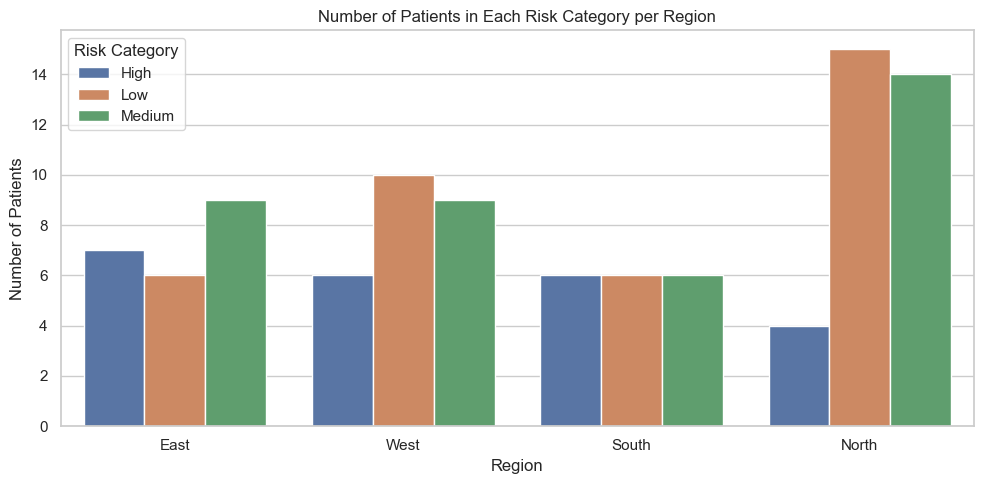

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")


plt.figure(figsize=(8, 5))
sns.boxplot(x="RiskCategory", y="BloodPressure", data=df_cleaned)
plt.title("Blood Pressure by Risk Category")
plt.xlabel("Risk Category")
plt.ylabel("Blood Pressure")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 5))
sns.countplot(x="Region", hue="RiskCategory", data=df_cleaned)
plt.title("Number of Patients in Each Risk Category per Region")
plt.xlabel("Region")
plt.ylabel("Number of Patients")
plt.legend(title="Risk Category")
plt.tight_layout()
plt.show()


3. Statistical Hypothesis Testing

In [6]:
from scipy.stats import ttest_1samp, chi2_contingency
import pandas as pd


sample = df_cleaned["CholesterolLevel"].sample(20, random_state=42)


t_stat, p_val = ttest_1samp(sample, popmean=200)

print("One-Sample T-Test:")
print("H₀: The mean CholesterolLevel = 200 mg/dL")
print("H₁: The mean CholesterolLevel ≠ 200 mg/dL")
print(f"Test Statistic (t): {t_stat:.4f}")
print(f"P-Value: {p_val:.4f}")

if p_val < 0.05:
    print("Interpretation: Reject H₀ — The average CholesterolLevel is significantly different from 200 mg/dL.\n")
else:
    print("Interpretation: Fail to Reject H₀ — No significant difference from 200 mg/dL.\n")


contingency = pd.crosstab(df_cleaned["Region"], df_cleaned["RiskCategory"])


chi2_stat, chi2_p_val, dof, expected = chi2_contingency(contingency)

print("Chi-Square Test of Independence:")
print("H₀: Region and RiskCategory are independent")
print("H₁: Region and RiskCategory are related")
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-Value: {chi2_p_val:.4f}")
print(f"Degrees of Freedom: {dof}")

if chi2_p_val < 0.05:
    print("Interpretation: Reject H₀ — There is a significant relationship between Region and RiskCategory.")
else:
    print("Interpretation: Fail to Reject H₀ — No significant relationship between Region and RiskCategory.")


One-Sample T-Test:
H₀: The mean CholesterolLevel = 200 mg/dL
H₁: The mean CholesterolLevel ≠ 200 mg/dL
Test Statistic (t): 1.1450
P-Value: 0.2664
Interpretation: Fail to Reject H₀ — No significant difference from 200 mg/dL.

Chi-Square Test of Independence:
H₀: Region and RiskCategory are independent
H₁: Region and RiskCategory are related
Chi-Square Statistic: 4.8247
P-Value: 0.5665
Degrees of Freedom: 6
Interpretation: Fail to Reject H₀ — No significant relationship between Region and RiskCategory.


4. Modeling a Health System with ODE

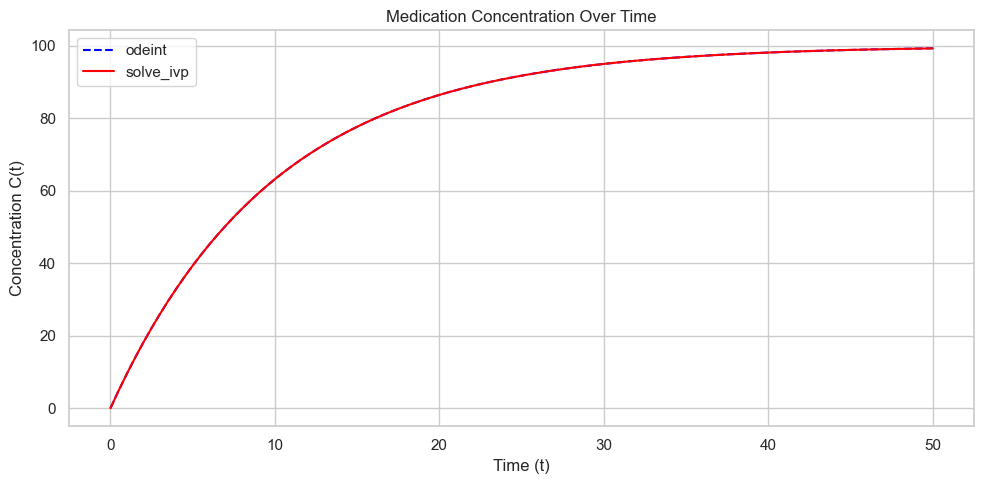


🧪 Explanation:
- Both `odeint` and `solve_ivp` solve the same ODE: dC/dt = k(D - C)
- The resulting curves are almost identical because this is a simple, well-behaved first-order equation.
- Any tiny differences are due to internal solver mechanisms (like Runge-Kutta vs LSODA).



In [7]:
from scipy.integrate import odeint, solve_ivp

#ODE: dC/dt = k(D - C)
def model(C, t, k, D):
    return k * (D - C)

def model_ivp(t, C, k, D):
    return [k * (D - C[0])]

C0 = 0      
k = 0.1     
D = 100     
t = np.linspace(0, 50, 200)  

C_odeint = odeint(model, C0, t, args=(k, D))

solution_ivp = solve_ivp(model_ivp, [0, 50], [C0], args=(k, D), t_eval=t)
C_ivp = solution_ivp.y[0]

plt.figure(figsize=(10, 5))
plt.plot(t, C_odeint, label="odeint", linestyle='--', color='blue')
plt.plot(t, C_ivp, label="solve_ivp", linestyle='-', color='red')
plt.title("Medication Concentration Over Time")
plt.xlabel("Time (t)")
plt.ylabel("Concentration C(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("""
🧪 Explanation:
- Both `odeint` and `solve_ivp` solve the same ODE: dC/dt = k(D - C)
- The resulting curves are almost identical because this is a simple, well-behaved first-order equation.
- Any tiny differences are due to internal solver mechanisms (like Runge-Kutta vs LSODA).
""")
